In [15]:
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
# Importer GlobalAveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import VGG16
! pip install gradio==3.50
import gradio as gr
import numpy as np
import os

In [2]:
# Load the pre-trained VGG16 model without the top layer
base_model = VGG16(weights='imagenet', include_top=False,
                   input_shape=(256, 256, 3))

# Add a GlobalAveragePooling2D layer to reduce feature dimensions
x = base_model.output
x = GlobalAveragePooling2D()(x)
model = Model(inputs=base_model.input, outputs=x)

# Directory containing the training and test images
train_dir = '/content/drive/MyDrive/ML Sport Project/train'
test_dir = '/content/drive/MyDrive/ML Sport Project/test'

58889256/58889256 [==============================] - 3s 0us/step


In [3]:
# Function to extract features from a single image

def extract_features(image_path):
    img = load_img(image_path, target_size=(256, 256))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalize pixel values
    # Extract features using VGG16
    features = model.predict(img_array).flatten()
    return features

In [4]:
# Load training and test images, then extract features
train_features = []
train_labels = []
for image_class in os.listdir(train_dir):
    class_path = os.path.join(train_dir, image_class)
    for image_name in os.listdir(class_path):
        image_path = os.path.join(class_path, image_name)
        features = extract_features(image_path)
        train_features.append(features)
        train_labels.append(image_class)

1/1 [==============================] - 0s 26ms/step


In [5]:
test_features = []
test_labels = []
for image_class in os.listdir(test_dir):
    class_path = os.path.join(test_dir, image_class)
    for image_name in os.listdir(class_path):
        image_path = os.path.join(class_path, image_name)
        features = extract_features(image_path)
        test_features.append(features)
        test_labels.append(image_class)

1/1 [==============================] - 0s 18ms/step


In [6]:
# Convert lists to numpy arrays
train_features = np.array(train_features)
train_labels = np.array(train_labels)
test_features = np.array(test_features)
test_labels = np.array(test_labels)

In [7]:
# Create a random forest classifier
forest_classifier = RandomForestClassifier(n_estimators=500)
forest_classifier.fit(train_features, train_labels)

RandomForestClassifier(n_estimators=500)

In [8]:
# Evaluate the random forest classifier on the test data
accuracy = forest_classifier.score(test_features, test_labels)
print(f'Accuracy of Random Forest Classifier: {accuracy}')

Accuracy of Random Forest Classifier: 0.9


In [9]:
# Predict classes on the test data
predicted_labels = forest_classifier.predict(test_features)

In [13]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(test_labels, predicted_labels)

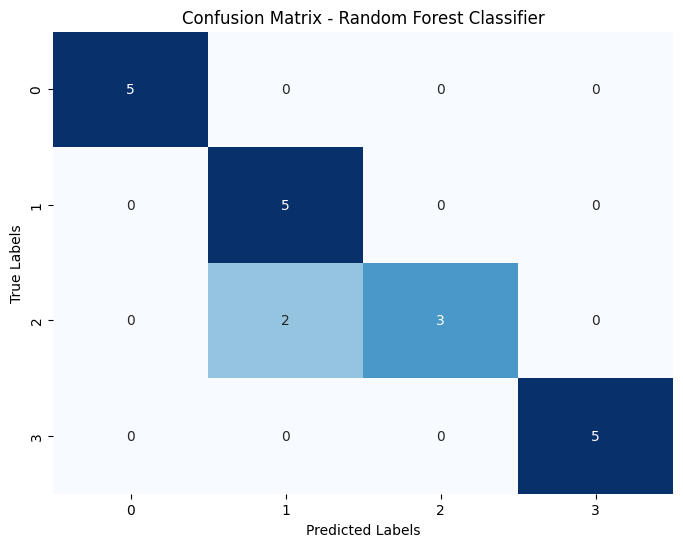

In [16]:
# Display the confusion matrix with seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Random Forest Classifier')
plt.show()

In [17]:
# Lists to store accuracy values
train_accuracies = []
test_accuracies = []

In [18]:
# Try different values for n_estimators
estimators_range = [50, 100, 200, 300, 500]

In [19]:
for estimators in estimators_range:
    # Create a random forest classifier with the given number of estimators
    forest_classifier = RandomForestClassifier(n_estimators=estimators)
    forest_classifier.fit(train_features, train_labels)

    # Evaluate the classifier on the training data
    train_accuracy = forest_classifier.score(train_features, train_labels)
    train_accuracies.append(train_accuracy)

    # Evaluate the classifier on the test data
    test_accuracy = forest_classifier.score(test_features, test_labels)
    test_accuracies.append(test_accuracy)

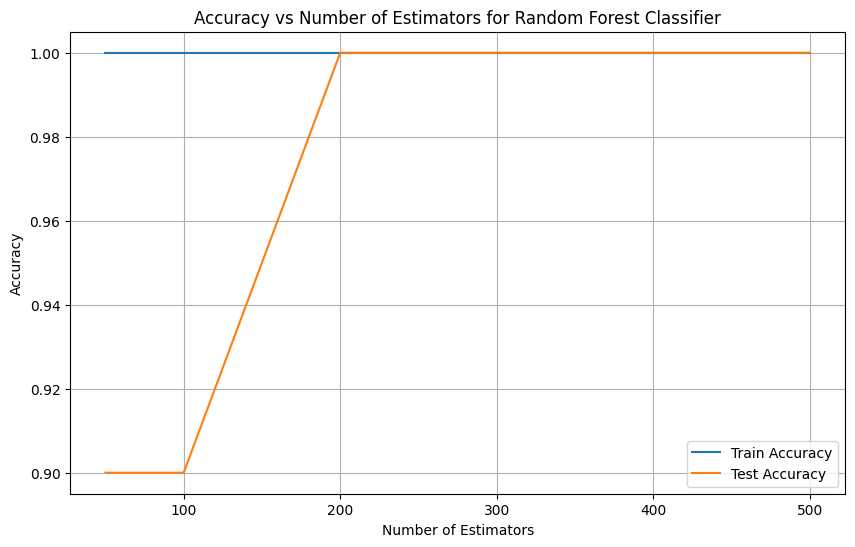

In [20]:
# Plot the accuracy curve as a function of the number of estimators
plt.figure(figsize=(10, 6))
plt.plot(estimators_range, train_accuracies, label='Train Accuracy')
plt.plot(estimators_range, test_accuracies, label='Test Accuracy')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Estimators for Random Forest Classifier')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
def predict_image(image):
    # Load the image with OpenCV
    # Resize the image to the size expected by VGG16
    img = cv2.resize(image, (256, 256))
    img = img.astype('float32') / 255.0  # Normaliser les valeurs des pixels

    # Extract features from the image using VGG16
    features = base_model.predict(np.expand_dims(img, axis=0))

    # Resize the features extracted by VGG16
    # Pool spatial features
    pooled_features = np.mean(features, axis=(1, 2))
    reshaped_features = pooled_features.reshape(
        1, -1)  # Flatten into a single line

    # Predict the class with the given classifier
    predicted_class = forest_classifier.predict(reshaped_features)[0]
    return predicted_class

In [22]:
# Path of the image to predict
image = cv2.imread("/content/drive/MyDrive/ML Sport Project/predict_images/golf1.jpeg")

# Use the function to predict the class of the image
predicted_class = predict_image(image)
print(f'The predicted class of the image is: {predicted_class}')


# Define the inputs and outputs for the Gradio interface
image = gr.inputs.Image(shape=(256, 256))
label = gr.outputs.Label()

# Launch the Gradio interface
gr.Interface(fn=predict_image, inputs=image, outputs=label).launch()


1/1 [==============================] - 0s 386ms/step
The predicted class of the image is: golf


<ipython-input-22-06e94931798d>:10: GradioDeprecationWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  image = gr.inputs.Image(shape=(256, 256))
<ipython-input-22-06e94931798d>:10: GradioDeprecationWarning: `optional` parameter is deprecated, and it has no effect
  image = gr.inputs.Image(shape=(256, 256))
<ipython-input-22-06e94931798d>:11: GradioDeprecationWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  label = gr.outputs.Label()
<ipython-input-22-06e94931798d>:11: GradioUnusedKwargWarning: You have unused kwarg parameters in Label, please remove them: {'type': 'auto'}
  label = gr.outputs.Label()


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
IMPORTANT: You are using gradio version 3.50.0, however version 4.29.0 is available, please upgrade.
--------
Running on public URL: https://d82993c58ab0bc6c39.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
